In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install transformers datasets wandb scikit-learn

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
import wandb


In [ ]:
wandb.login()

# Set up the W&B project
wandb.init(project="fake_news_detector", entity="username or team")  # Replace with your username or team

In [7]:
# Load train and test data
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/multilingual_dataset_train_final.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/multilingual_dataset_test_final.csv")

# Reduce dataset size for memory efficiency (0.001 of the data)
train_data = train_data.sample(frac=0.001, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=0.001, random_state=42).reset_index(drop=True)

# Preprocess dataset
def preprocess_data(data):
    data = data.rename(columns={"text_column": "text", "label_column": "labels"})
    return data

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

datasets = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})


In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

# Tokenize the datasets
tokenized_datasets = datasets.map(tokenize_function, batched=True)

# Remove the text column (not needed after tokenization)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# Set the dataset format for PyTorch
tokenized_datasets.set_format("torch")


Map:   0%|          | 0/66 [00:00<?, ? examples/s]

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

In [9]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary", zero_division=0)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [10]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",       # Save model at each epoch
    learning_rate=2e-5,          # Keep the learning rate the same
    per_device_train_batch_size=4,  # Adjust batch size if possible
    gradient_accumulation_steps=1,  # Disable accumulation for small datasets
    per_device_eval_batch_size=8,
    num_train_epochs=5,          # Number of epochs
    weight_decay=0.01,           # Regularization for better generalization
    logging_dir="./logs",        # Directory for logs
    logging_steps=1,             # Log every step (small datasets)
    load_best_model_at_end=True, # Load the best model based on validation
    metric_for_best_model="f1",  # Use F1 for model selection
    save_total_limit=2,          # Keep only 2 checkpoint saves to save space
    push_to_hub=False            # No need to push to HuggingFace hub
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
# Load the pre-trained model with two output labels
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,  # Ensure training_args is defined elsewhere
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Ensure compute_metrics is defined elsewhere
)

# Train the model
trainer.train()

# Save the trained model and tokenizer
save_path = "/content/fine_tuned_model"  # Define the path to save your model
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved to {save_path}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-8b2845cfc325>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.602600,0.640774,0.608696,0.608696,1.000000,0.756757
2,0.666200,0.558688,0.608696,0.608696,1.000000,0.756757
3,0.856200,0.462981,0.782609,0.736842,1.000000,0.848485
4,0.323000,0.412581,0.782609,0.736842,1.000000,0.848485
5,0.284000,0.401888,0.782609,0.736842,1.000000,0.848485


Model and tokenizer saved to /content/fine_tuned_model


In [12]:
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.46298056840896606, 'eval_accuracy': 0.782608695652174, 'eval_precision': 0.7368421052631579, 'eval_recall': 1.0, 'eval_f1': 0.8484848484848485, 'eval_runtime': 21.9259, 'eval_samples_per_second': 1.049, 'eval_steps_per_second': 0.137, 'epoch': 5.0}


In [13]:
# Extract training metrics and save to CSV
logs = pd.DataFrame(trainer.state.log_history)
logs.to_csv("training_logs.csv", index=False)
print("Training logs saved as 'training_logs.csv'")


Training logs saved as 'training_logs.csv'


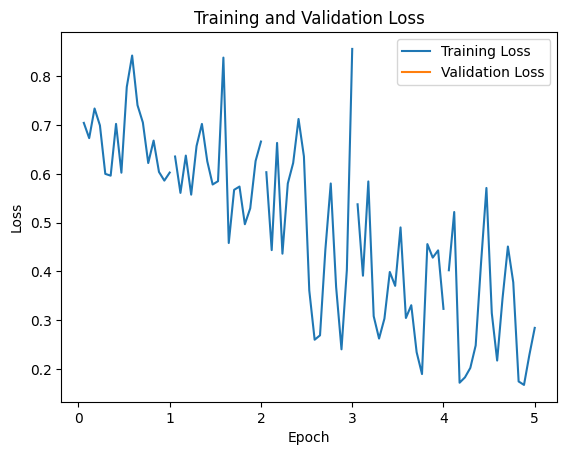

In [14]:
import matplotlib.pyplot as plt

logs = pd.read_csv("training_logs.csv")

plt.plot(logs["epoch"], logs["loss"], label="Training Loss")
plt.plot(logs["epoch"], logs["eval_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig("training_curve.png")
plt.show()


In [15]:
!pip install gradio

In [16]:
import gradio as gr
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Path to your saved fine-tuned model
saved_model_path = "/content/fine_tuned_model"  # Change this to your saved model directory

# Load the fine-tuned model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(saved_model_path)
model = AutoModelForSequenceClassification.from_pretrained(saved_model_path)

# Prediction function
def predict_text(text):
    # Tokenize the input text
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )
    with torch.no_grad():
        # Make predictions
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = np.argmax(logits.numpy(), axis=1)[0]
    return "Fake News" if prediction == 1 else "Real News"

# Create Gradio interface
interface = gr.Interface(
    fn=predict_text,                     # Function to process input
    inputs=gr.Textbox(label="Enter News Text"),  # Input box for user text
    outputs=gr.Label(label="Prediction"),       # Display prediction
    title="Fake News Detector",
    description="Enter a news article or headline, and the model will predict whether it's Real News or Fake News."
)

# Launch the interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9d5893e7370a2d8036.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [17]:
import shutil

# Compress the folder into a zip file
shutil.make_archive('fine_tuned_model', 'zip', './fine_tuned_model')

print("Folder 'fine_tuned_model' has been compressed into 'fine_tuned_model.zip'.")

Folder 'fine_tuned_model' has been compressed into 'fine_tuned_model.zip'.
